# Spectral Analysis

## Theoretical Approach
In this stage, we transition from the time domain to the frequency domain. The objective is to analyze the noisy signal generated in the previous step and identify its constituent frequencies.

We will implement the **Discrete Fourier Transform** from first principles using Linear Algebra. We treat the transformation as a change of basis, where the new basis vectors correspond to orthogonal complex sinusoids.

We will explicitly construct the **Fourier Matrix** and perform the transformation via matrix-vector multiplication. Following the transformation, we will apply a **hard threshold filter** in the frequency domain to separate the significant signal components from the stochastic noise.

## Mathematical Formulation

The DFT transforms a finite sequence of $N$ complex numbers $\mathbf{x} = [x_0, x_1, \dots, x_{N-1}]^T$ into another sequence of $N$ complex numbers $\mathbf{X} = [X_0, X_1, \dots, X_{N-1}]^T$.

This operation is defined as a linear transformation:

$$
\mathbf{X} = F \cdot \mathbf{x}
$$

### The Fourier Matrix
The transformation matrix $F$ is an $N \times N$ matrix. It is a specific type of **Vandermonde Matrix** based on the $N$-th roots of unity.

We define the fundamental root of unity $\omega_N$ as:
$$
\omega_N = e^{-i \frac{2\pi}{N}}
$$

The element in the $j$-th row and $k$-th column of the matrix $F$ is given by the power of this root:
$$
F_{j,k} = \omega_N^{j \cdot k} = e^{-i \frac{2\pi}{N} j k}
$$

The full matrix structure represents the $N$ frequency vectors as rows, testing the $N$ time samples as columns:

$$
F =
\begin{bmatrix}
1 & 1 & 1 & \dots & 1 \\
1 & \omega_N & \omega_N^2 & \dots & \omega_N^{N-1} \\
1 & \omega_N^2 & \omega_N^4 & \dots & \omega_N^{2(N-1)} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & \omega_N^{N-1} & \omega_N^{2(N-1)} & \dots & \omega_N^{(N-1)(N-1)}
\end{bmatrix}
$$

### Symmetry and the Nyquist Frequency
For real-valued input signals, the resulting DFT spectrum exhibits conjugate symmetry. The coefficients at indices $k$ and $N-k$ are complex conjugates:

$$
X_k = X_{N-k}^*
$$

This implies that their magnitudes are identical, $|X_k| = |X_{N-k}|$, meaning the second half of the spectrum is a mirror image of the first.

The **Nyquist Frequency** corresponds to the index $k = N/2$. It represents the highest frequency resolvable by the sampling rate $f_s$:

$$
f_{\text{Nyquist}} = \frac{f_s}{2}
$$

Because of this symmetry, spectral analysis typically focuses only on the range of indices $k \in [0, N/2]$, which corresponds to frequencies $f \in [0, f_{\text{Nyquist}}]$.

### Libraries Import

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Configuration Analysis

In [2]:
# Data Configuration
input_filename = "signal_data.csv"
output_filename = "frequency_data.csv"

# Noise threshold
THRESHOLD_MAGNITUDE = 40.0

### Data Processing

In [3]:
# Loading data
df = pd.read_csv(input_filename)
signal_x = df["signal_amplitude"].values
time_t = df["time_s"].values

# Extracting signal parameters
N = len(signal_x)
T_s = time_t[1] - time_t[0]
fs = 1.0 / T_s

print(f"Loaded signal with {N} samples.")
print(f"Derived sampling rate: {fs:.2f} Hz")

Loaded signal with 256 samples.
Derived sampling rate: 1000.00 Hz


### Fourier Matrix Construction

In [ ]:
def create_dft_matrix(n_samples):
    # Defining grid
    j = np.arange(n_samples).reshape(-1, 1)
    k = np.arange(n_samples).reshape(1, -1)

    # Calculating the exponent constant
    exponent_constant = -2j * np.pi / n_samples

    # 3. Creating the matrix
    F = np.exp(exponent_constant * j * k)

    return F

F_matrix = create_dft_matrix(N)
print(f"DFT Matrix Shape: {F_matrix.shape}")

DFT Matrix Shape: (256, 256)


### Performing the Transformation

In [5]:
# Matrix multiplication
X_complex = np.dot(F_matrix, signal_x)

# Calculating frequency bins
freq_bins = np.arange(N) * (fs / N)

# Calculating magnitudes
X_magnitude = np.abs(X_complex)

### Visualizing the Raw Spectrum

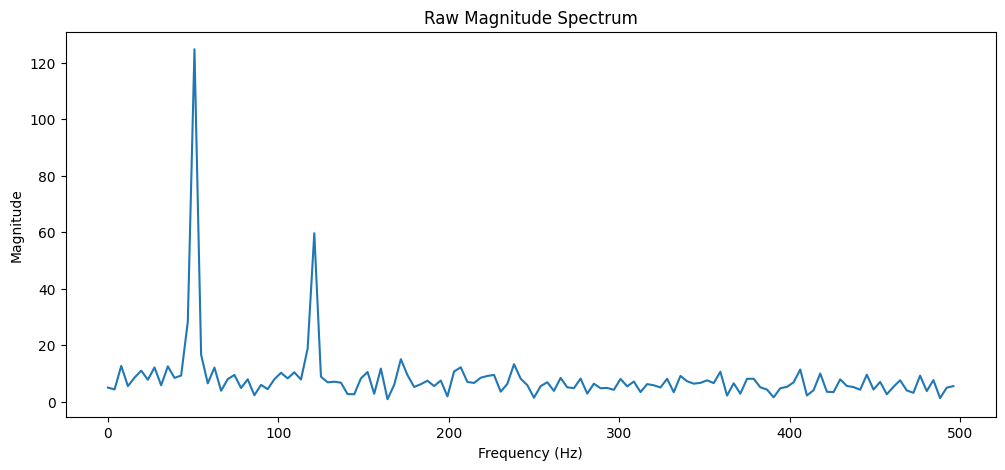

In [6]:
# Visualization of the Raw Spectrum
plt.figure(figsize=(12, 5))

# Plotting 0 to Nyquist
half_N = N // 2
plt.plot(freq_bins[:half_N], X_magnitude[:half_N])
plt.title("Raw Magnitude Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.show()

### Threshold Filtering

In [7]:
# Creating copy
X_filtered = X_complex.copy()

# Identifying noise indices
noise_indices = np.abs(X_filtered) < THRESHOLD_MAGNITUDE

# Applying Filter
X_filtered[noise_indices] = 0.0 + 0.0j

# Counting remaining components
non_zero_count = np.count_nonzero(X_filtered)
print(f"Original Non-Zero Components: {N}")
print(f"Remaining Significant Components: {non_zero_count}")

Original Non-Zero Components: 256
Remaining Significant Components: 4


### Visualizing the Filtered Spectrum

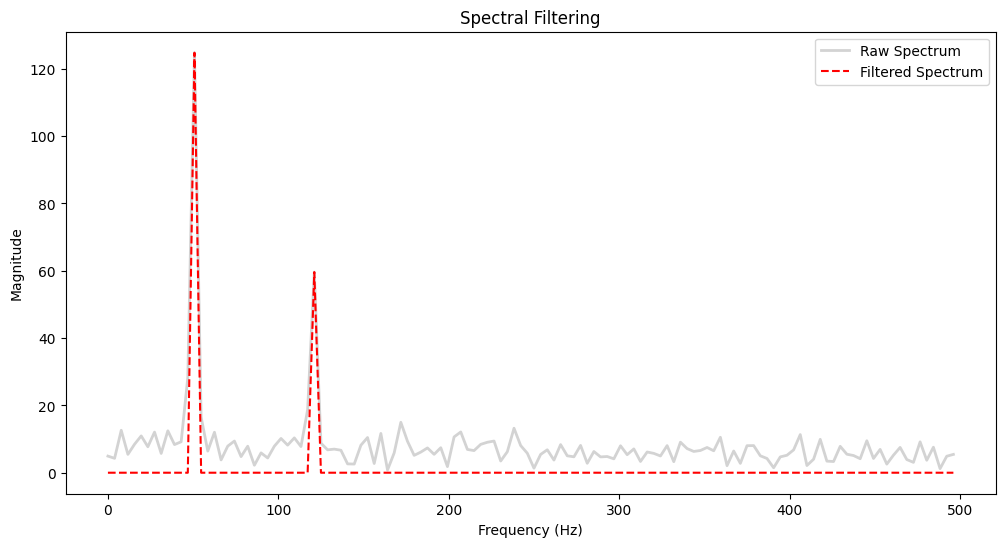

In [9]:
plt.figure(figsize=(12, 6))

# Plotting original spectrum
plt.plot(freq_bins[:half_N], np.abs(X_complex[:half_N]),
         label="Raw Spectrum", color="lightgray", linewidth=2)

# Plotting filtered spectrum
plt.plot(freq_bins[:half_N], np.abs(X_filtered[:half_N]),
         label="Filtered Spectrum", color="red", linestyle="--", linewidth=1.5)

plt.title("Spectral Filtering")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend()
plt.show()

### Data Export

In [12]:
# Preparing dataframe
df_freq = pd.DataFrame({
    "frequency_hz": freq_bins,
    "X_real": X_filtered.real,
    "X_imag": X_filtered.imag
})

# Saving to CSV
df_freq.to_csv(output_filename, index=False)

print(f"Frequency data saved to '{output_filename}'")

Frequency data saved to 'frequency_data.csv'
